In [1]:
library("DESeq2")
library("pheatmap")
library("ggplot2")
library("reshape")
library("plotly")
library("grid")
library("gridExtra")
library("plyr")
library("VennDiagram")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

In [2]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

# Import data

Here, I import the un-normalized read counts from StringTie output as a count matrix for DESeq2.

First, import the gene counts as a matrix:

In [9]:
c <- read.csv("gene_count_matrix_sorted.csv", row.names=1)
gcts <- as.matrix(c)
head(gcts)

,R1C24A,R1C24B,R1C24C,R1C24D,R1C48A,R1C48B,R1C48C,R1C48D,R1C72A,R1C72B,⋯,S2Q24C,S2Q24D,S2Q48A,S2Q48B,S2Q48C,S2Q48D,S2Q72A,S2Q72B,S2Q72C,S2Q72D
1,26,24,22,22,21,21,27,25,25,36,⋯,17,12,16,13,19,20,0,12,19,15
2,1849,1981,1858,1955,2183,2243,2156,2372,3410,3571,⋯,1986,1981,2208,2191,2095,2229,2013,2226,2125,2244
3,17,30,0,27,12,21,1,17,10,44,⋯,3,10,20,0,10,10,2,9,7,13
4,78,32,52,42,26,25,55,15,48,27,⋯,37,0,29,55,27,23,36,32,11,33
5,55,54,36,80,59,44,52,67,145,119,⋯,158,170,199,177,182,182,155,185,176,182
6,426,357,515,597,631,588,590,604,881,576,⋯,690,495,638,615,593,631,672,529,672,621


Now the same but for the transcript counts:

In [10]:
c <- read.csv("transcript_count_matrix.csv", row.names=1)
tcts <- as.matrix(c)
head(tcts)

,R1C24A,R1C24B,R1C24C,R1C24D,R1C48A,R1C48B,R1C48C,R1C48D,R1C72A,R1C72B,⋯,S2Q24C,S2Q24D,S2Q48A,S2Q48B,S2Q48C,S2Q48D,S2Q72A,S2Q72B,S2Q72C,S2Q72D
MSTRG.9396.8,0,0,0,0,16,0,0,0,5,51,⋯,3,6,6,5,39,2,0,37,0,98
MSTRG.22509.1,5,2,3,2,6,5,2,6,6,7,⋯,10,22,19,19,14,13,22,20,10,21
MSTRG.2044.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,13,0,4,1,0,1,5,5
MSTRG.12668.1,1246,1183,1218,1168,824,829,816,869,1212,1287,⋯,806,908,715,657,721,669,679,689,661,654
MSTRG.18752.1,297,281,313,283,254,225,198,182,295,342,⋯,398,414,359,318,313,329,317,321,358,368
MSTRG.8651.1,0,0,2,2,0,8,2,5,3,6,⋯,7,3,0,0,0,3,4,2,3,3


Finally, I create the sample the sample information table as a data frame:

In [11]:
colcols <- c("exp", "cond", "hpi", "rep_bio", "rep_tec")

coldata <- read.csv("pheno_data.csv", row.names=1, strip.white=T)
coldata <- coldata[, colcols]

# Correct the technical replicate column for later collapsing
coldata$rep_tec <- c(rep(1:4, each=4), c(5,5,5), rep(6:24, each=4))
head(coldata)

,exp,cond,hpi,rep_bio,rep_tec
R1C24A,R,C,24h,1,1
R1C24B,R,C,24h,1,1
R1C24C,R,C,24h,1,1
R1C24D,R,C,24h,1,1
R1C48A,R,C,48h,1,2
R1C48B,R,C,48h,1,2


Just checking for consistency between the rows of the sample information table and the columns in the count matrices.

In [12]:
# Check with the gene counts
all(rownames(coldata) %in% colnames(gcts))
# Check with the transcript counts
all(rownames(coldata) %in% colnames(tcts))

[1] TRUE

[1] TRUE

Finally, the DESeqDataSet objects can be created. 

In [13]:
gdds <- DESeqDataSetFromMatrix(countData = gcts,
                               colData = coldata,
                               design = ~ cond)
tdds <- DESeqDataSetFromMatrix(countData = tcts,
                               colData = coldata,
                               design = ~ cond)
summary(gdds)
summary(tdds)

      Length        Class         Mode 
       24413 DESeqDataSet           S4 

      Length        Class         Mode 
       55493 DESeqDataSet           S4 

I'll also load an annotations file containing the information of chromosome and position for each gene id

In [14]:
annot <- read.csv("annotations.txt", header=F)
colnames(annot) <- c("gene_id", "chr", "g_star", "g_end")
# Re-order annotation gene_ids according to the order in the data set
annot <- annot[match(rownames(gdds), annot$gene_id),]
head(annot)

gene_id,chr,g_star,g_end
1,0,29755,30541
2,0,68426,86044
3,0,97938,99413
4,0,98077,101005
5,0,182612,193163
6,0,196283,206073


# Collapse technical replicates

DESeq2 provides a function collapseReplicates which can assist in combining the counts from technical replicates into single columns of the count matrix. The term technical replicate implies multiple sequencing runs of the same library.

In [15]:
gdds <- collapseReplicates(gdds, gdds$rep_tec)

In [16]:
mcols(gdds) <- cbind(mcols(gdds), annot)

# Data exploration

DESeq2 offers some ways of exploring the data before undertaking the differential gene expression analysis. 

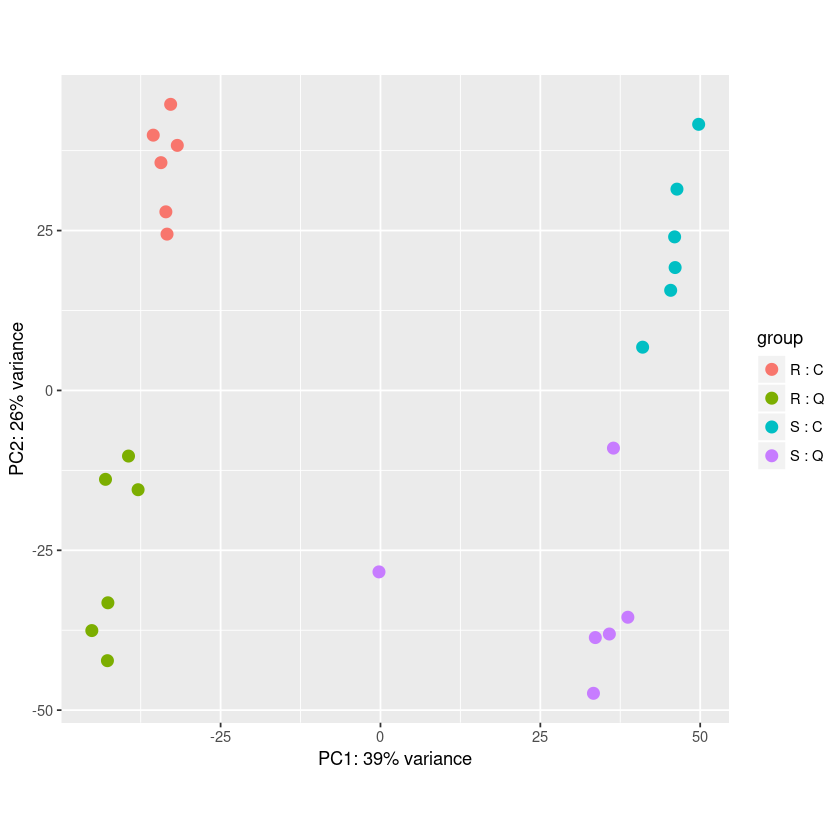

In [17]:
ntd <- normTransform(gdds)
plotPCA(ntd, intgroup=c("exp", "cond"))

# Differential expression analyses

## 1º Question: What are the DE genes for each time point and host phenotype between the control and inoculated groups?

Here,I'll perform pairwise comparisons for each HPI and plant phenotype (e.g. Resistant at 24HPI; Susceptible at 24HPI, etc.). To this end, I create a new subset for each comparison from the main DESeqDataset. **In all of the following cases, the variable being compared is Control vs Inoculated**.

In [18]:
### subset conditions ###
pair_cond = list(
    # Resistant at 24HPI
    "rh24c" = colData(gdds)$hpi=="24h" & colData(gdds)$exp=="R",
    # Resistant at 48HPI
    "rh48c" = colData(gdds)$hpi=="48h" & colData(gdds)$exp=="R",
    # Resistant at 72HPI
    "rh72c" = colData(gdds)$hpi=="72h" & colData(gdds)$exp=="R",
    # Susceptible at 24HPI
    "sh24c" = colData(gdds)$hpi=="24h" & colData(gdds)$exp=="S",
    # Susceptible at 48HPI
    "sh48c" = colData(gdds)$hpi=="48h" & colData(gdds)$exp=="S",
    # Susceptible at 72HPI
    "sh72c" = colData(gdds)$hpi=="72h" & colData(gdds)$exp=="S",
    ######
    # Control at 24HPI
    "c24" = colData(gdds)$cond=="C" & colData(gdds)$hpi=="24h",
    # Control at 48HPI
    "c48" = colData(gdds)$cond=="C" & colData(gdds)$hpi=="48h",
    # Control at 72HPI
    "c72" = colData(gdds)$cond=="C" & colData(gdds)$hpi=="72h"
)

In [19]:
getpair_stats <- function(ds, cond) {
    pc <- unlist(pair_cond[cond])
    sdd <- subset(ds, select=pc)
    
    if (cond %in% c("c24", "c48", "c72")) {
        design(sdd) <- formula(~ exp)
    }
    
    sddd <- DESeq(sdd);
    sddres <- results(sddd, alpha=0.05, lfcThreshold=1, altHypothesis="greaterAbs")
    
    #print(sdd@colData)
    print(paste("Data set with ", nrow(sdd@colData), " samples and ", length(sdd@rowRanges), " genes."))
    #print(sddres)
    print(paste("Total of significant DE :", sum(sddres$padj <= 0.05, na.rm=T)))
    
    return(list("res"=sddres, "ds"=sdd))
}

### Resistant at 24HPI

In [20]:
rh24 <- getpair_stats(gdds, "rh24c")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 74"


In [21]:
write.table(as.matrix(rh24$res), file="rh24c.csv", , quote=F, sep=";")

In [22]:
gene_ids = rownames(as.data.frame(subset(rh24$res, rh24$res$padj <= 0.05)))
write(gene_ids, file="resistant24hpi.txt")

### Resistant at 48HPI

In [23]:
rh48 <- getpair_stats(gdds, "rh48c")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 181"


In [24]:
write.table(as.matrix(rh48$res), file="rh48c.csv", , quote=F, sep=";")

In [25]:
gene_ids = rownames(as.data.frame(subset(rh48$res, rh48$res$padj <= 0.05)))
write(gene_ids, file="resistant48hpi.txt")

### Resistant at 72HPI

In [26]:
rh72 <- getpair_stats(gdds, "rh72c")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 590"


In [27]:
write.table(as.matrix(rh72$res), file="rh72c.csv", , quote=F, sep=";")

In [28]:
gene_ids = rownames(as.data.frame(subset(rh72$res, rh72$res$padj <= 0.05)))
write(gene_ids, file="resistant72hpi.txt")

### Susceptible at 24HPI

In [29]:
sh24 <- getpair_stats(gdds, "sh24c")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 14"


In [30]:
write.table(as.matrix(sh24$res), file="sh24c.csv", , quote=F, sep=";")

In [31]:
gene_ids = rownames(as.data.frame(subset(sh24$res, sh24$res$padj <= 0.05)))
write(gene_ids, file="susceptible24hpi.txt")

### Susceptible at 48HPI

In [32]:
sh48 <- getpair_stats(gdds, "sh48c")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 214"


In [33]:
write.table(as.matrix(sh48$res), file="sh48c.csv", , quote=F, sep=";")

In [34]:
gene_ids = rownames(as.data.frame(subset(sh48$res, sh48$res$padj <= 0.05)))
write(gene_ids, file="susceptible48hpi.txt")

### Susceptible at 72HPI

In [35]:
sh72 <- getpair_stats(gdds, "sh72c")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 272"


In [36]:
write.table(as.matrix(sh72$res), file="sh72c.csv", , quote=F, sep=";")

In [37]:
gene_ids = rownames(as.data.frame(subset(sh72$res, sh72$res$padj <= 0.05)))
write(gene_ids, file="susceptible72hpi.txt")

### 1.1 Question: What are the trends of DEG for each host phenotype across time points?

First, a simple comparison of the significant DE genes for each plant phenotype across all three HPI points.

In [38]:
pairsr <- list(
    "rh24" = rh24,
    "rh48" = rh48,
    "rh72" = rh72
)

pairss <- list(
    "sh24" = sh24,
    "sh48" = sh48,
    "sh72" = sh72
)

Using x as id variables


,x,r,s
rh24,h24,74,14
rh48,h48,181,214
rh72,h72,590,272


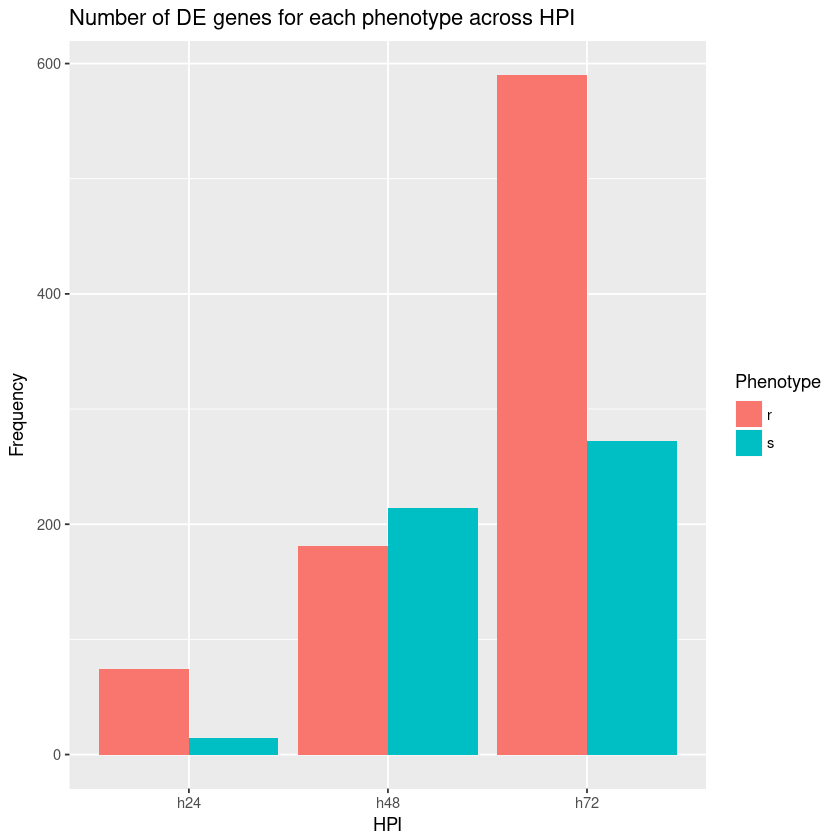

In [39]:
x <- data.frame(
    "x"=c("h24", "h48", "h72"),
    "r"=unlist(lapply(pairsr, function(x) sum(x$res$padj <= 0.05, na.rm=T))),
    "s"=unlist(lapply(pairss, function(x) sum(x$res$padj <= 0.05, na.rm=T)))
)
x.m <- melt(x)

p <- ggplot(x.m, aes(x, value)) +
    geom_bar(aes(fill=variable), stat = "identity", position="dodge") +
    xlab("HPI")+ ylab("Frequency") + ggtitle ("Number of DE genes for each phenotype across HPI") +
    scale_fill_discrete(name = "Phenotype")

p
x

When comparing the control with the inoculate group, we observed a substantical increase in the number of DEG along time for both host phenotypes. This increase, as well as the absolute number of DEG, is higher in the resistant phenotype. With the exception of the 48h time point, the number of DEG was between 2-3.5x higher than in the susceptible phenotype.

 ### 1.1.1 Question: What is the contribution of up and down regulated DEG for each host phenotype along time?

Using x as id variables


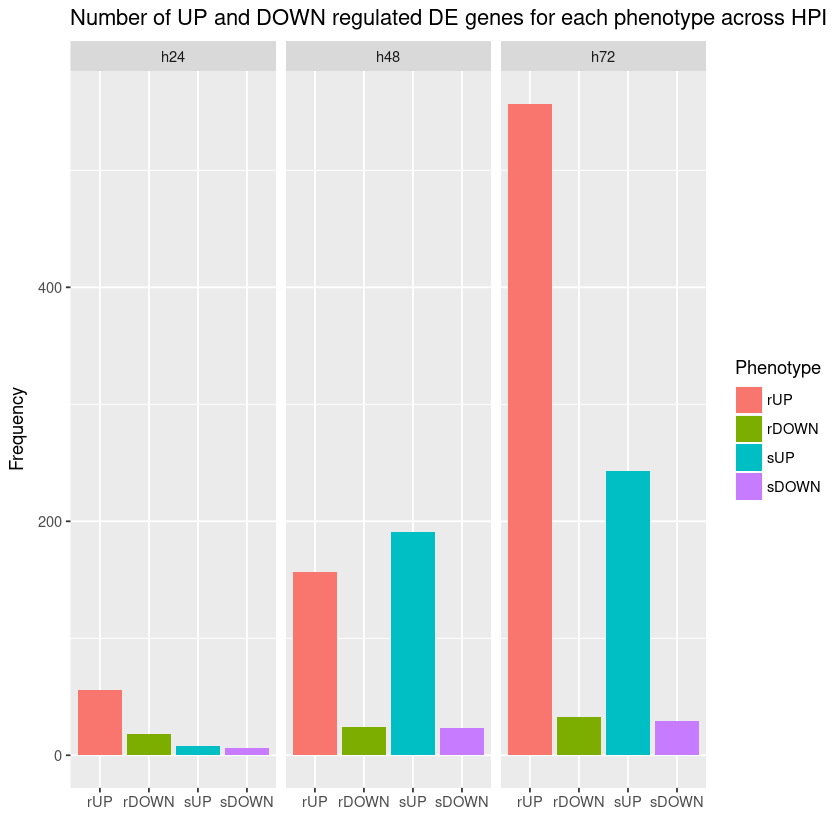

In [40]:
x <- data.frame(
    "x"=c("h24", "h48", "h72"),
    "rUP"=unlist(lapply(pairsr, function(x) sum(subset(x$res, x$res$padj <= 0.05)$log2FoldChange >= 1, na.rm=T))),
    "rDOWN"=unlist(lapply(pairsr, function(x) sum(subset(x$res, x$res$padj <= 0.05)$log2FoldChange <= -1, na.rm=T))),
    "sUP"=unlist(lapply(pairss, function(x) sum(subset(x$res, x$res$padj <= 0.05)$log2FoldChange >= 1, na.rm=T))),
    "sDOWN"=unlist(lapply(pairss, function(x) sum(subset(x$res, x$res$padj <= 0.05)$log2FoldChange <= -1, na.rm=T)))
)
x.m <- melt(x)

p <- ggplot(x.m, aes(variable, value,fill=variable)) +
    geom_bar(aes(), stat = "identity", position="dodge") +
    facet_wrap(~x, ncol=3) +
    xlab("")+ ylab("Frequency") + ggtitle("Number of UP and DOWN regulated DE genes for each phenotype across HPI") +
    scale_fill_discrete(name = "Phenotype")

p
#x.m

As we can see, the majority of the DE genes are being upregulated, and they are the main contributors to the difference in total DEG between phenotypes across HPI points. This seems to lead to the conclusion that the response to the presence of the pathogen in either host results mostly in an increase of gene expression. As noted before, the number of up-regulated DEG is much higher in the resistant phenotype and seems to be elicited earlier.

### 1.2.1 Question:  For each host genotype, what is the overllap of DE genes over time points?

Is there a great proportion of DEG shared across all time points? What are the time point combinations with the most shared DEG? What is the time point with the highest proportion of exclusive DEG?

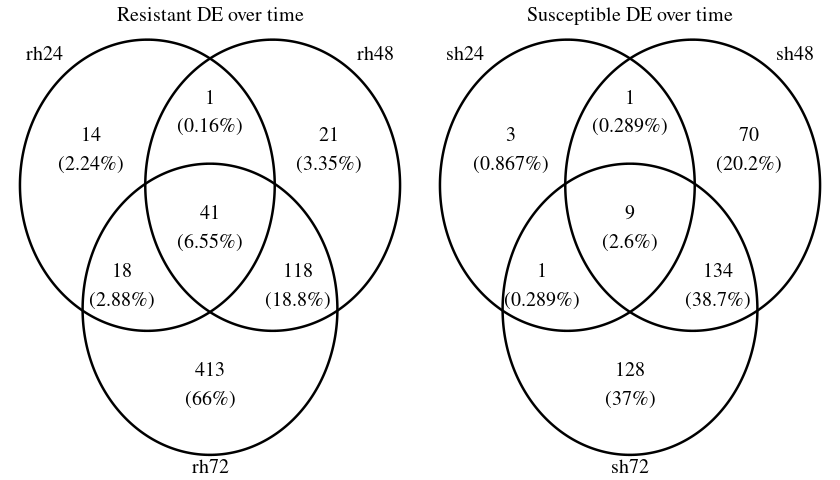

In [41]:
# Subset the results of each time point and get the rownames, which contain the number of the gene.
rh24_gi <- rownames(subset(rh24$res, rh24$res$padj <= 0.05))
rh48_gi <- rownames(subset(rh48$res, rh48$res$padj <= 0.05))
rh72_gi <- rownames(subset(rh72$res, rh72$res$padj <= 0.05))

ven_rh <- list(
    rh24=rh24_gi,
    rh48=rh48_gi,
    rh72=rh72_gi
)

rh_ven <- venn.diagram(ven_rh, main="Resistant DE over time", filename=NULL,print.mode=c("raw", "percent"))

# Subset the results of each time point and get the rownames, which contain the number of the gene.
sh24_gi <- rownames(subset(sh24$res, sh24$res$padj <= 0.05))
sh48_gi <- rownames(subset(sh48$res, sh48$res$padj <= 0.05))
sh72_gi <- rownames(subset(sh72$res, sh72$res$padj <= 0.05))

ven_sh <- list(
    sh24=sh24_gi,
    sh48=sh48_gi,
    sh72=sh72_gi
)

sh_ven <- venn.diagram(ven_sh, main="Susceptible DE over time", filename=NULL, print.mode=c("raw", "percent"))

library(repr)
options(repr.plot.height=4)
grid.arrange(gTree(children=rh_ven), gTree(children=sh_ven), ncol=2, nrow=1, heights=c(1), widths=c(1,1))

Overall, the overlap of DEG for each phenotype across all combinations of time points was fairly low. The number of  DEG significant at **all** time points was 45 (6.23%) and 10 (2.38%) for the resistant and susceptible phenotypes, respectively. 

Starting with 24HPI point, we can see that the majority of the DEG in the **resistant** phenotype (67%) are actually shared with other time points. In fact, almost half (44.11%) of the DEG genes at 24HPI remain differentially expressed across all remaining time points. However, genes that are DE at 24h very rarely (3.9%) remain expressed only until the 48HPI point. On the other hand, 19.61% of the genes with differential expression at 24HPI cease to have differential expression at 48h and return as DEG at the 72HPI point. This trend is very similar to the one observed for the **susceptible** phenotype.

At the 48HPI point, we can see that in both phenotyes, the majority of the DGE (59.34% for resistant and 57.20% forsusceptible) are shared with the 72HPI. As previously noted, there are very few DGE shared only with the 24HPI point.

At the 72HPI point, we can see that (particularly for the resistant phenotype) the majority of the DEG are exclusive of that time point. 

The overall conclusion from these results are that there is tendency for genes that are differentially expressed at a given time point, to continue to be so along time. Nevertheless, the proportion of DEG that occur at all time points is very low. It also seems to be very rare for genes to be differentially expressed at the first two time points and then cease to be so in the 72HPI point. The majority of the DEG seem to appear at the last time point, as demonstrated by the fact that the number of exclusive genes for the 72HPI is always the highest.

## 1.2.2 Question:  For each host time point, what is the overlap of DE genes between phenotypes?

Are the same genes being expressed in both phenotypes at each time point? And is this sharing consistent across time points? At which time point do they share the most DEG?

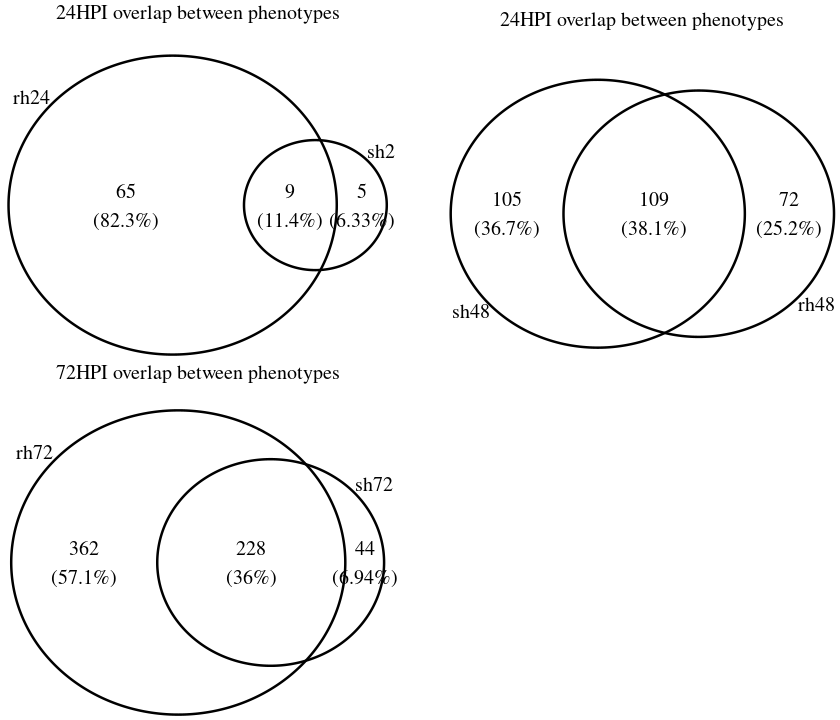

In [42]:
# Subset the results of each time point and get the rownames, which contain the number of the gene.
rh24_gi <- rownames(subset(rh24$res, rh24$res$padj <= 0.05))
sh24_gi <- rownames(subset(sh24$res, sh24$res$padj <= 0.05))

ven_24h <- list(
    rh24=rh24_gi,
    sh24=sh24_gi
)

h24_ven <- venn.diagram(ven_24h, main="24HPI overlap between phenotypes", filename=NULL, print.mode=c("raw", "percent"))

# Subset the results of each time point and get the rownames, which contain the number of the gene.
rh48_gi <- rownames(subset(rh48$res, rh48$res$padj <= 0.05))
sh48_gi <- rownames(subset(sh48$res, sh48$res$padj <= 0.05))

ven_48h <- list(
    rh48=rh48_gi,
    sh48=sh48_gi
)

h48_ven <- venn.diagram(ven_48h, main="24HPI overlap between phenotypes", filename=NULL, print.mode=c("raw", "percent"))

# Subset the results of each time point and get the rownames, which contain the number of the gene.
rh72_gi <- rownames(subset(rh72$res, rh72$res$padj <= 0.05))
sh72_gi <- rownames(subset(sh72$res, sh72$res$padj <= 0.05))

ven_72h <- list(
    rh72=rh72_gi,
    sh72=sh72_gi
)

h72_ven <- venn.diagram(ven_72h, main="72HPI overlap between phenotypes", filename=NULL, imagetype="png",print.mode=c("raw", "percent"))

library(repr)
options(repr.plot.height=6)
blank<-rectGrob(gp=gpar(col="white"))
grid.arrange(gTree(children=h24_ven), blank, gTree(children=h48_ven), gTree(children=h72_ven), ncol=3, nrow=2, widths=c(0.8, 0.1, 0.8))

Assessing the overlap between host phenotypes across all time points provides an interesting insight. Despite starting with rather different sets of DEG (8 genes; 27%), there is a clear trend for the increase in the overlap of DEG over time. This increases reaches its maximum at the last time point where almost 80% of the DEG in the susceptible phenotype are also found in the set of DEG from the resistant phenotype.

A tantalizing suggestion from these results, is that the core response for "resistance" may not be very different between both genotypes over time. However, the response is elicited much earlier in the resistant phenotype, and having an earlier kick-off to that response appears to be the key. Over time, the overlap of DEG for both hosts clearly seems to converge in a pattern similar to an eclipse.

## 1.3 Question: How does the fold change distributes according to the normalized read counts for each condition?

Now we can also plot the distribution of the log2 fold changes for each condition over the mean of normalized counts for all samples.

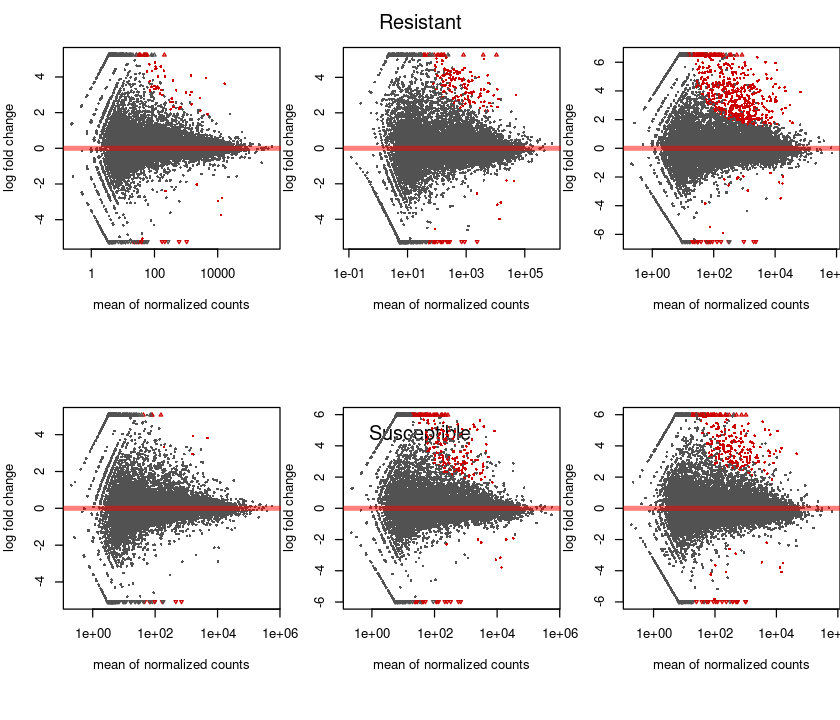

In [43]:
multiMA <- function(x) {
    plotMA(x$res)
}

par(mfrow = c(2,3), mar=c(7, 4, 3, 0))


y <- lapply(pairsr, multiMA)
mtext("Resistant", side = 3, line = -2, outer = TRUE)
mtext("Susceptible", side = 3, line = -28, outer = TRUE)
mtext("24HPI", at = 0.18, side = 3, line = -52, outer = TRUE)
mtext("48HPI", at = 0.53, side = 3, line = -52, outer = TRUE)
mtext("72HPI", at = 0.85, side = 3, line = -52, outer = TRUE)
y <- lapply(pairss, multiMA)

In [44]:
plotFC <- function(ds, title) {
    ds$chr <- mcols(gdds)$chr;
    mdf <- data.frame("gene" = rownames(ds),
                      "chr" = mcols(gdds)$chr ,
                      "fc" = ds$log2FoldChange,
                      "qval" = ds$padj)
    df <- subset(mdf, mdf$qval <= 0.05)
    dfc <- count(df, "chr")
    p <- ggplot(df, aes(as.numeric(rownames(df)), fc)) +
        geom_point(aes(color=fc)) +
        geom_hline(data = dfc,
                   aes(yintercept=freq * (max(df$fc) / max(dfc$freq)), alpha=.7, text=paste("Frequency: ", freq)),
                   colour="red") + 
        facet_grid(~chr, scales="free_x") +
        scale_colour_gradientn(colours=rainbow(7)) +
        xlab("Genome position") +
        ggtitle(paste(title, "(", sum(dfc$freq) ,")")) + 
        theme(axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              panel.spacing=unit(0.15, "lines"))
        #scale_y_continuous(name = "log2(FC)",
        #                   sec.axis = sec_axis(~ . * (max(df$fc) / max(dfc$freq)) , name = "Frequency"),
        #                   limits = c(min(df$fc), max(df$fc)))
    
    p
    
}

The number of DE genes tends to increase with the number of HPI and with a clear distribution skewed torwards up-regulated genes.

### 1.4 Question: How do DEG distribute for each condition across the genome?

### Resistant phenotype

Warning message:
“Ignoring unknown aesthetics: text”

Warning message:
“Ignoring unknown aesthetics: text”

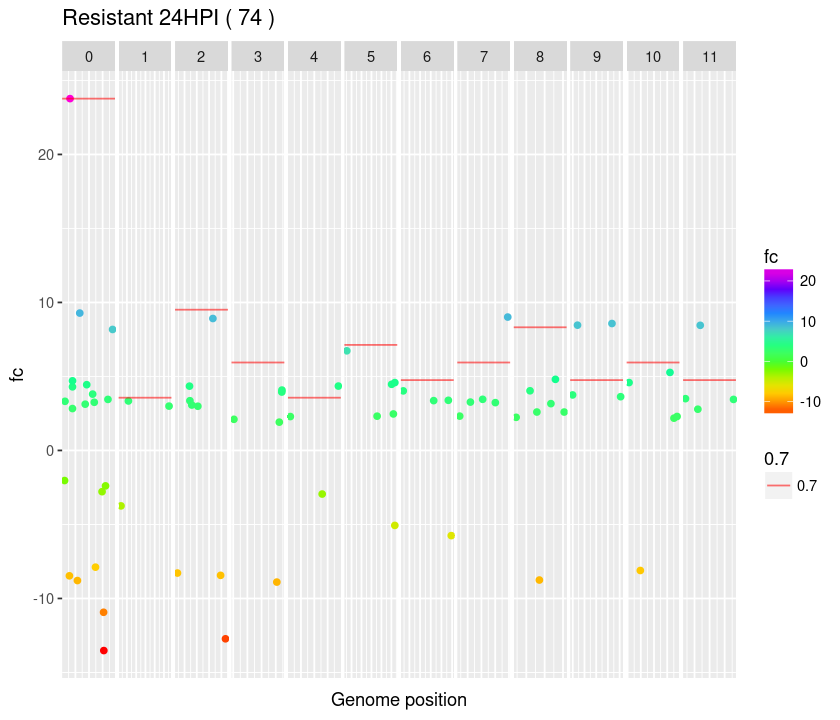

Warning message:
“Ignoring unknown aesthetics: text”

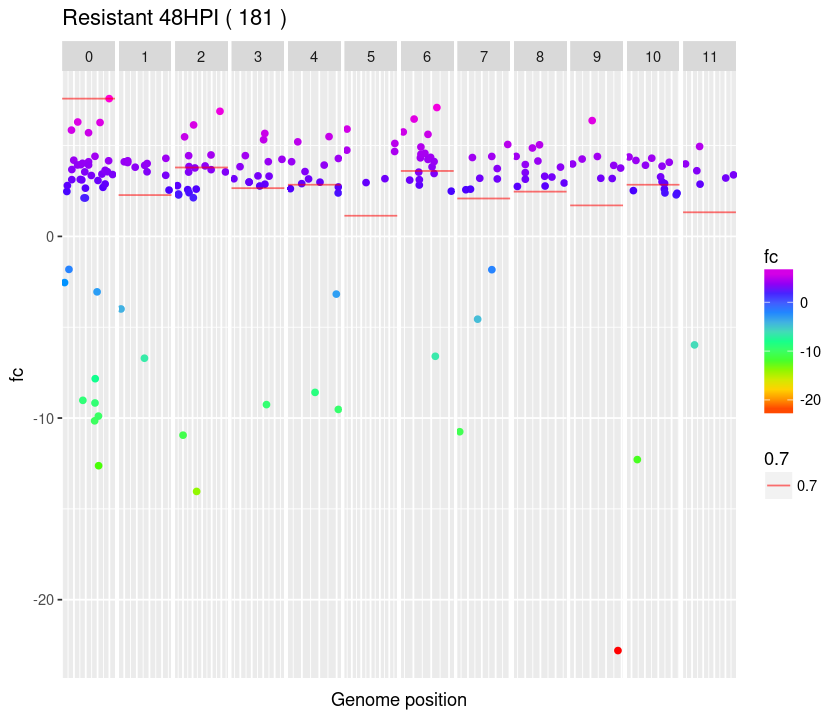

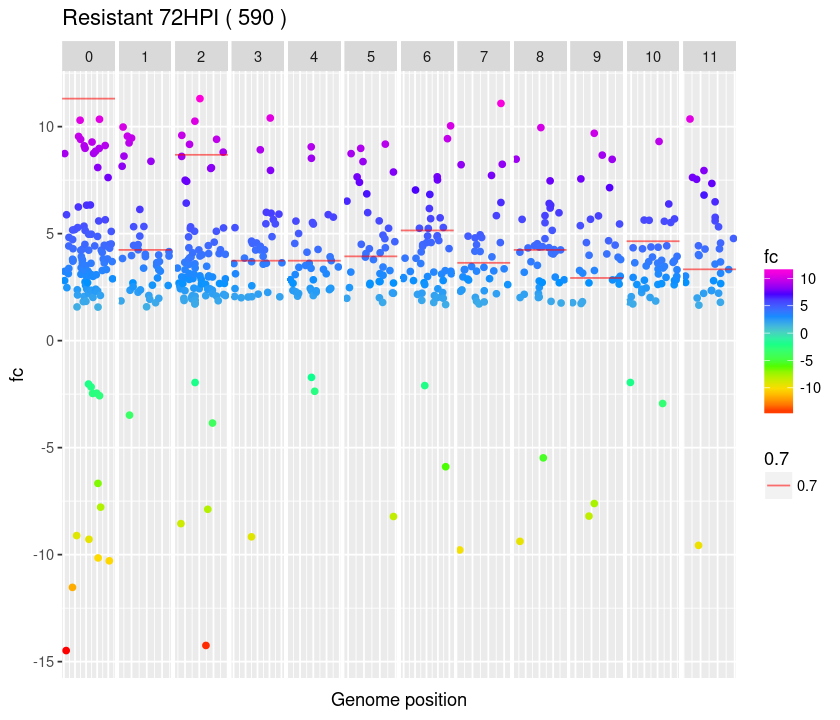

In [45]:
plotFC(rh24$res, "Resistant 24HPI")
plotFC(rh48$res, "Resistant 48HPI")
plotFC(rh72$res, "Resistant 72HPI")

### Susceptible phenotype

Warning message:
“Ignoring unknown aesthetics: text”

Warning message:
“Ignoring unknown aesthetics: text”

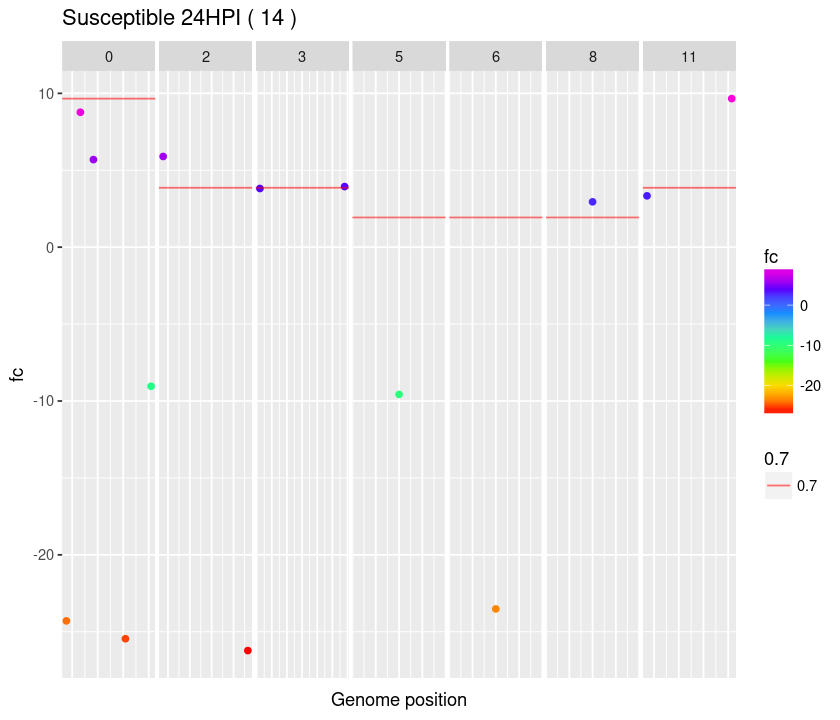

Warning message:
“Ignoring unknown aesthetics: text”

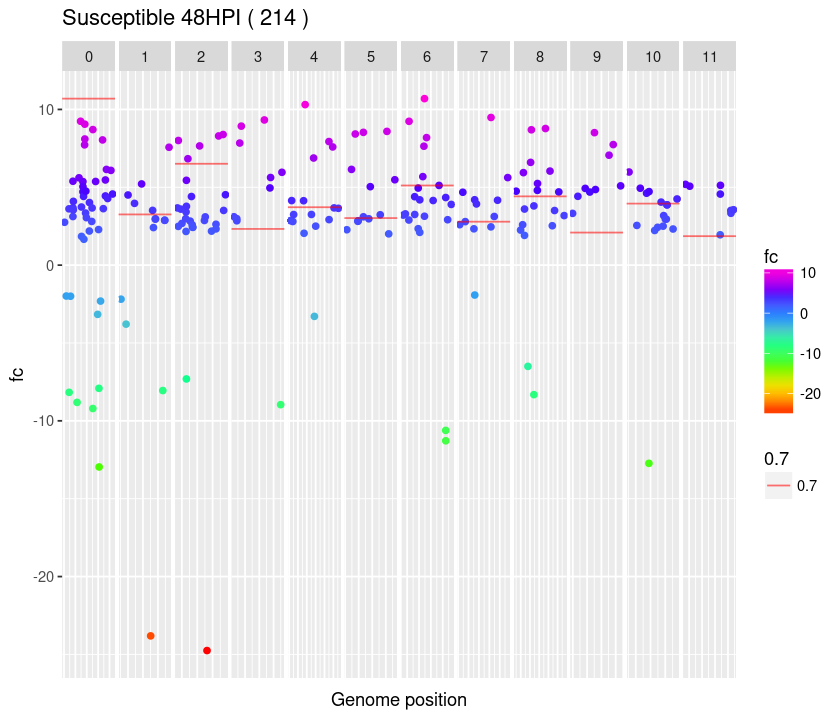

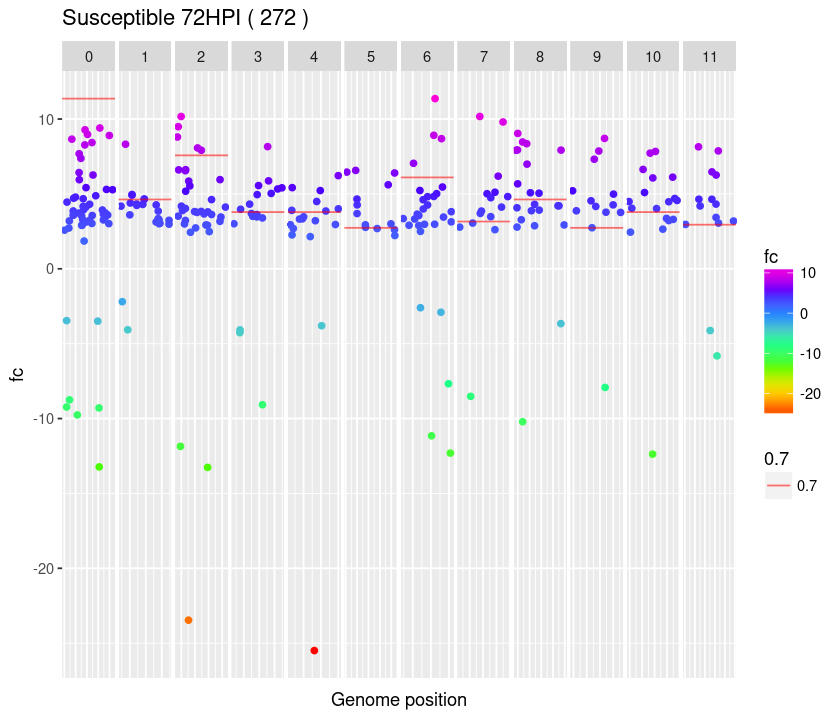

In [46]:
plotFC(sh24$res, "Susceptible 24HPI")
plotFC(sh48$res, "Susceptible 48HPI")
plotFC(sh72$res, "Susceptible 72HPI")

## Time-course DE

For a control and treatment time series, one can use a design formula containing the condition factor, the time factor, and the interaction of the two. In this case, using the likelihood ratio test with a reduced model which does not contain the interaction terms will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0).

Time-course experiments allow the explicit discovery of genes that have differential expression between two conditions **over time**. Previously, we tested whether a particular gene was differentially expressed between host phenotypes at any particular point in time. In this experiment, DE genes with low p-values will be the ones that show a host-specific effect **over time** after time 0.

In [47]:
get_tcstats <- function(ds) {
    design(ds) <- formula(~ cond + hpi + cond:hpi);
    dsd <- DESeq(ds, test="LRT", reduced=~ cond + hpi);
    res <- results(dsd);
    return(list("res"=res, "ds"=dsd))
}

get_tcstats_cond <- function(ds) {
    design(ds) <- formula(~ exp + hpi + exp:hpi);
    dsd <- DESeq(ds, test="LRT", reduced=~ exp + hpi);
    res <- results(dsd, alpha=0.05);
    return(list("res"=res, "ds"=dsd))
}

# 3º Question: How does gene expression between control and inoculated conditions evolve over time?

### 3.1 Question: Which genes show DE over time for the resistant phenotype? 

In [48]:
# Subset the data to include only Q samples
rqt = colData(gdds)$exp=="R"
rds <- subset(gdds, select=rqt)

rtc <- get_tcstats(rds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [49]:
length(which(rtc$res$padj <= 0.05))

[1] 76

In [50]:
write.table(as.matrix(rtc$res), file="rtc.csv", , quote=F, sep=";")

In [51]:
rtc_ids = row.names(as.data.frame(subset(rtc$res, rtc$res$padj <= 0.05)))
write(rtc_ids, "resistant_timecourse.txt")

For the resistant phenotype, there are 83 genes that show a significant change in expression between control and inoculated conditions over time. This means that, at some point in time, these genes displayed a different expression over the transition to a particular time point between the control and inoculated groups.

We can also plot the profile of each DEG over time using an heatmap as below:

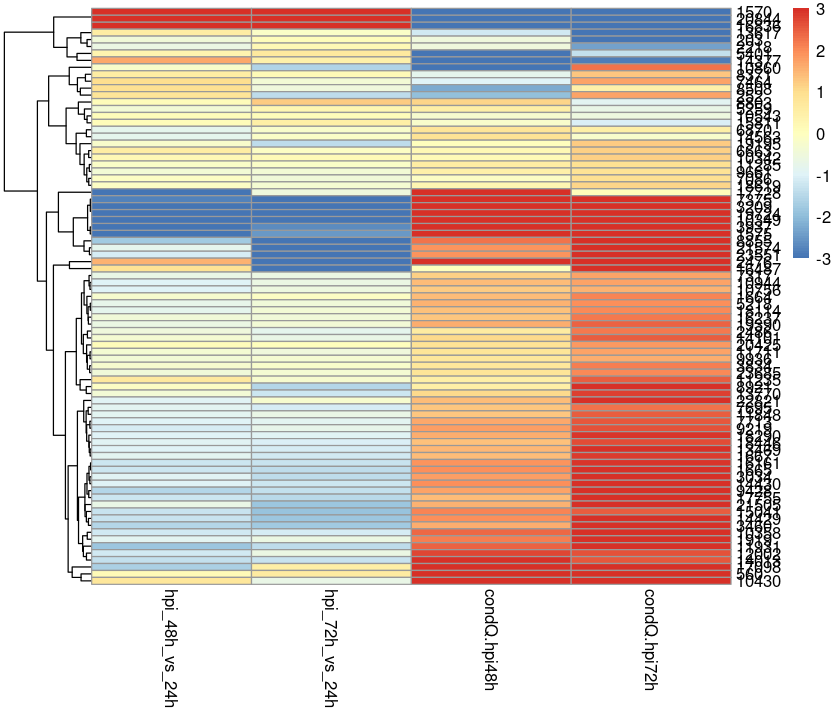

In [52]:
betas <- coef(rtc$ds)
topGenes <- head(order(rtc$res$padj), 83)

mat <- betas[topGenes, -c(1,2)]

thr <- 3
mat[mat < -thr] <- -thr
mat[mat > thr] <- thr

pheatmap(mat, breaks=seq(from=-thr, to=thr, length=101), cluster_col=F)

From the heatmap above, we can see from the last 2 columns (condQ.hpi48h and condQ.hpi72h) the expression profile of each of the 83 significant genes over time. For example, the first gene (row) displayed a strong induction of expression between the 24-48h and then regressed to expression levels similar to the control. For the majority of these genes, there seems to be a strong induction of expression over time, reaching maximum values when transitioning to the last time point. However, a group of roughly 20 genes (at the bottom of the heatmap) also displayed a strong downregulation on the inoculated group over time.

If we were interested in the particular profile of a certain gene, we could also model the read counts of that gene as a smooth function of time, and include an interaction term of the condition with the smooth function. Let's demonstrate with the first gene in the above heatmap, 18841.

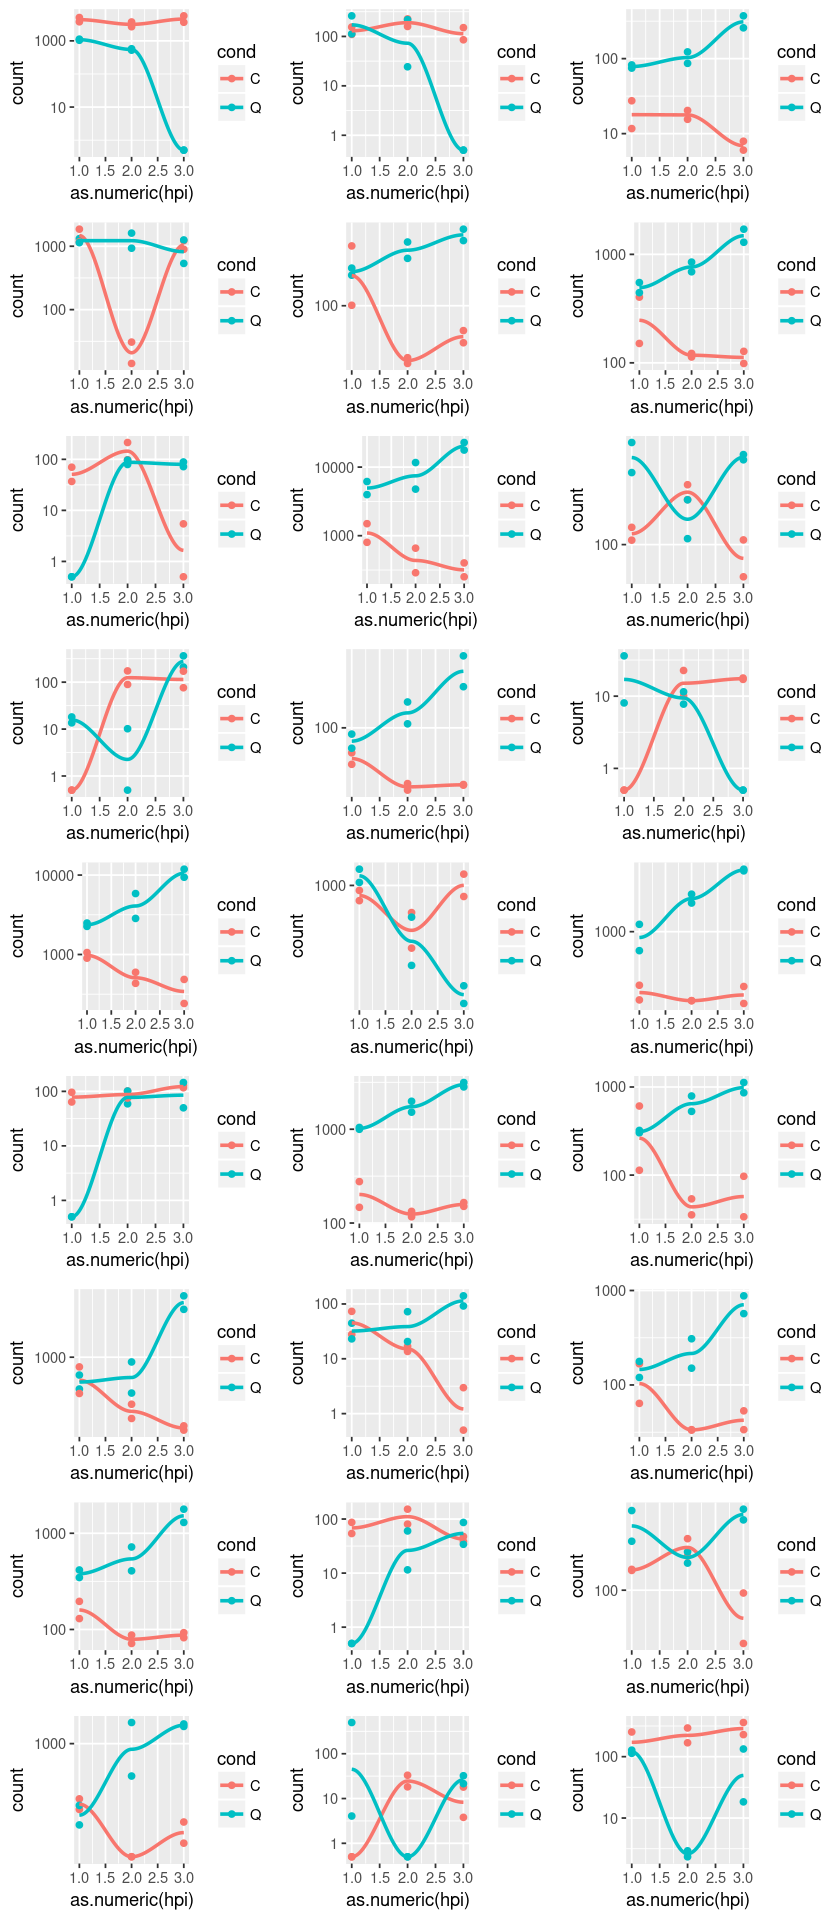

In [53]:
options(warn=-1)
sprof <- function(gnID) {
    fiss <- plotCounts(rtc$ds, gnID, 
                       intgroup = c("hpi","cond"), returnData = TRUE)
    p <- ggplot(fiss,
      aes(x = as.numeric(hpi), y = count, color = cond, group = cond)) +
      geom_point() + geom_smooth(se = FALSE, method = "loess") + scale_y_log10()
    return(p)
}

gene27 <- head(order(rtc$res$padj), 27)

z <- lapply(gene27, sprof)

options(repr.plot.height=16)
multiplot(plotlist=z, cols=3)

### 3.1 Question: Which genes show DE over time for the resistant phenotype? 

In [54]:
# Subset the data to include only Q samples
sqt = colData(gdds)$exp=="S"
sds <- subset(gdds, select=sqt)

stc <- get_tcstats(sds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [55]:
length(which(stc$res$padj <= 0.05))

[1] 14

In [56]:
write.table(as.matrix(stc$res), file="stc.csv", , quote=F, sep=";")

In [57]:
stc_ids = row.names(as.data.frame(subset(stc$res, stc$res$padj <= 0.05)))
write(stc_ids, "susceptible_timecourse.txt")

As we can see, the number DEG over time for the susceptible host is much lower than in the resistant host. This is an expected result from the previous analyses where each time point was compared independently for both hosts, where the susceptible host showed less DEG.

We can perform the same heatmap analysis to see the profile of the significant DE.

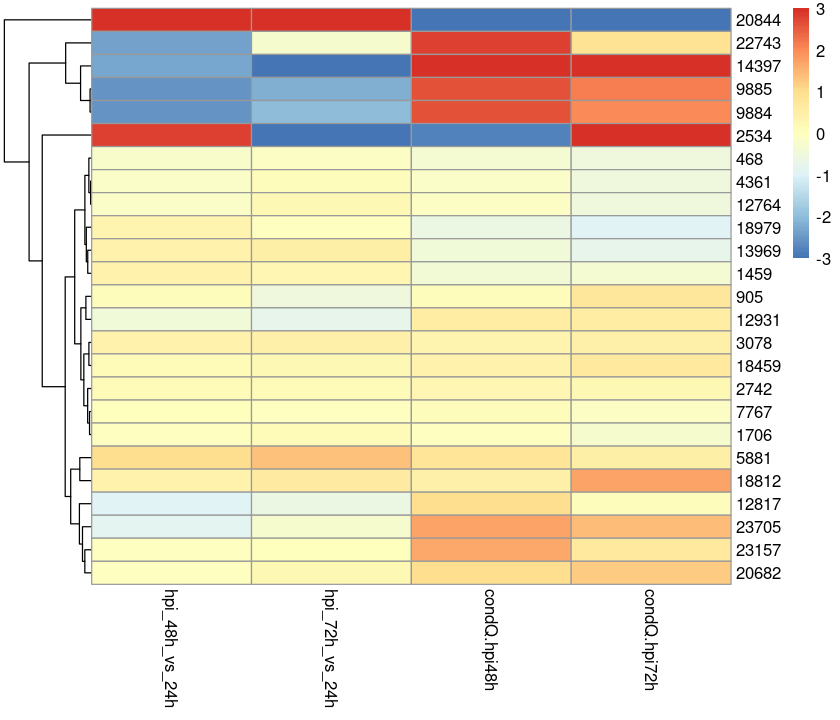

In [58]:
sbetas <- coef(stc$ds)
stopGenes <- head(order(stc$res$padj), 25)

smat <- betas[stopGenes, -c(1,2)]

thr <- 3
smat[smat < -thr] <- -thr
smat[smat > thr] <- thr

options(repr.plot.height=6)
pheatmap(smat, breaks=seq(from=-thr, to=thr, length=101), cluster_col=F)

Unlike the heatmap for the resistant host, this showed a much lesser trend of strong induction in the inoculated group. In fact, almost half of the DEG showed an variable degree of down-regulation, compared to the control group.

We can now assess the overlap of these DEG between the resistant and susceptible hosts.

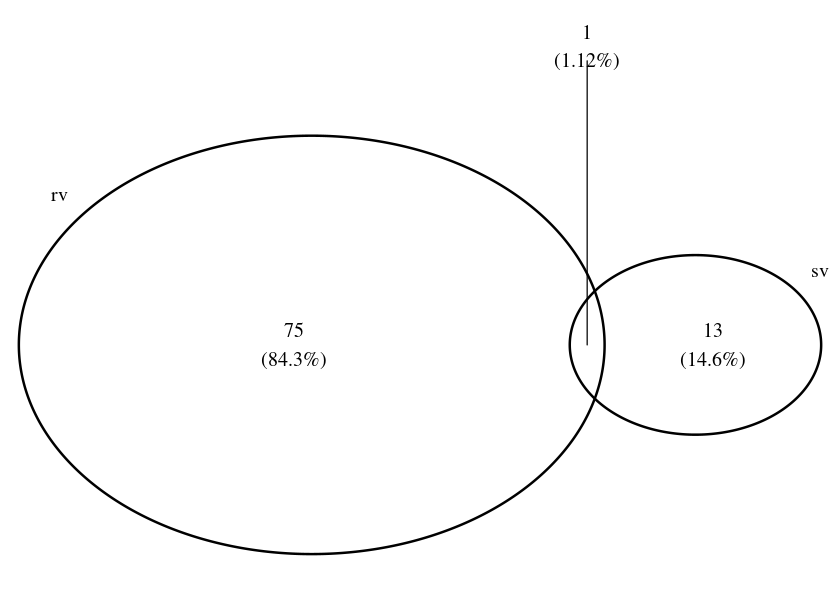

In [59]:
rde <- which(rtc$res$padj <= 0.05)
sde <- which(stc$res$padj <= 0.05)

tc_ds <- list(
    "rv" = rde,
    "sv" = sde
)
options(repr.plot.height=5)
tc_ven <- venn.diagram(tc_ds, filename=NULL,  imagetype="png",print.mode=c("raw", "percent"))
grid.draw(tc_ven)

Interestingly, only one DEG is shared between the resistant and susceptible hosts, which means that the genes that are being elicited over time are almost completely different between these hosts.

Finally, we can also plot the distribution of the DEG over time along the genome for both hosts.

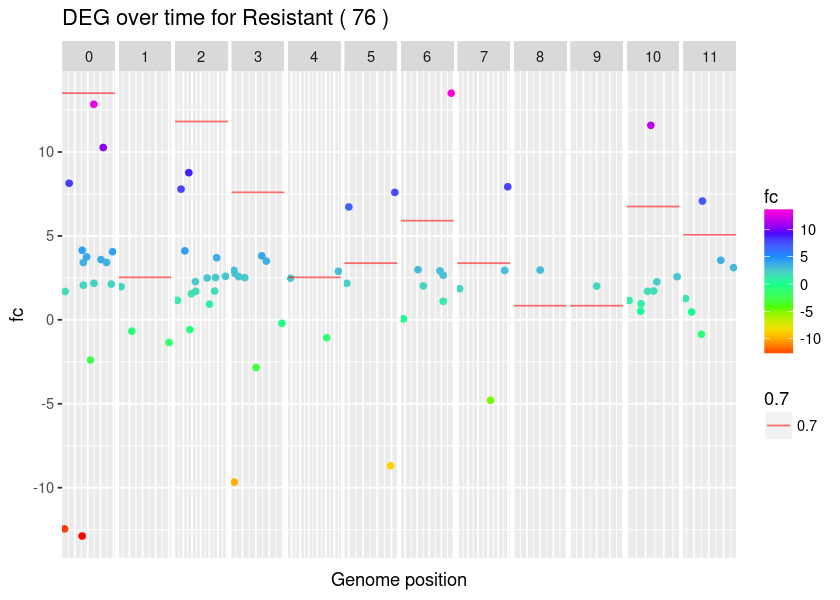

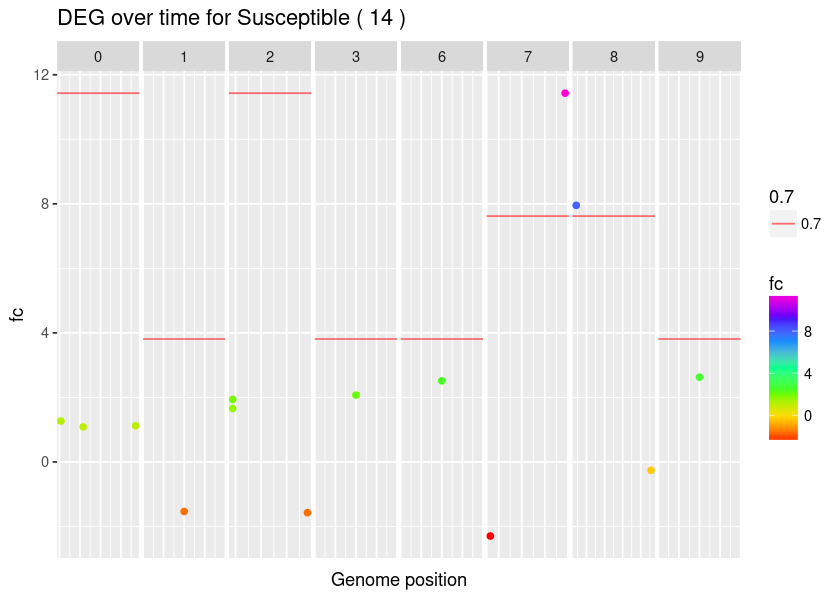

In [60]:
plotFC(rtc$res, "DEG over time for Resistant")
plotFC(stc$res, "DEG over time for Susceptible")

It is noteworthy that, as in the independent time point comparisons performed before, Chr2 consistently displays the highest number of DEG.

## 4º Question: Which genes are DE at each time point between control and inoculated in function of the host phenotype?

The question that will be addressed here is which genes are DE between control vs. inoculated **and** resistant vs. susceptible. The rationale is very similar to the time-course experiment, but replacing the cond:hpi interaction with cond:exp.

In [61]:
hpi24_c <- colData(gdds)$hpi=="24h"
hpi48_c <- colData(gdds)$hpi=="48h"
hpi72_c <- colData(gdds)$hpi=="72h"

hpi_intest <- function(sel) {
    ss <- subset(gdds, select=sel)
    design(ss) <- formula(~ cond + exp + cond:exp);
    dsd <- DESeq(ss, test="LRT", reduced=~ cond + exp);
    res <- results(dsd, alpha=.05);
    print(length(which(res$padj <= 0.05)))
    return(list("res"=res, "ds"=dsd))
}

In [62]:
hpi24i <- hpi_intest(hpi24_c)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] 11


In [63]:
hpi48i <- hpi_intest(hpi48_c)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] 12


In [64]:
hpi72i <- hpi_intest(hpi72_c)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] 42


# Table creation

In [65]:
na_conv <- function(df) {
    ndf <- df;
    ndf[ndf > 0.05] <- NA;
    return(ndf)
}

ds_v <- list(rh24$res$padj,rh48$res$padj, rh72$res$padj,
             sh24$res$padj, sh48$res$padj, sh72$res$padj,
             rtc$res$padj, stc$res$padj,
             hpi24i$res$padj, hpi48i$res$padj, hpi72i$res$padj)

ds_p <- rapply(ds_v, na_conv, how="list")

main_df <- data.frame(
    "rh24"=ds_p[[1]],
    "rh48"=ds_p[[2]],
    "rh72"=ds_p[[3]],
    "sh24"=ds_p[[4]],
    "sh48"=ds_p[[5]],
    "sh72"=ds_p[[6]],
    "rtc"=ds_p[[7]],
    "stc"=ds_p[[8]],
    "hpi24i"=ds_p[[9]],
    "hpi48i"=ds_p[[10]],
    "hpi72i"=ds_p[[11]]
)

#Remove rows containing only NA
final_df <- main_df[rowSums(is.na(main_df)) != 11,]

nrow(final_df)

write.csv(final_df, file="DEG.csv")

[1] 738

## 3º Question: Which genes are DEG in a control setting between the two hosts

In [66]:
c24 <- getpair_stats(gdds, "c24")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 164"


In [67]:
c48 <- getpair_stats(gdds, "c48")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 212"


In [68]:
c72 <- getpair_stats(gdds, "c72")

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Data set with  4  samples and  24413  genes."
[1] "Total of significant DE : 254"


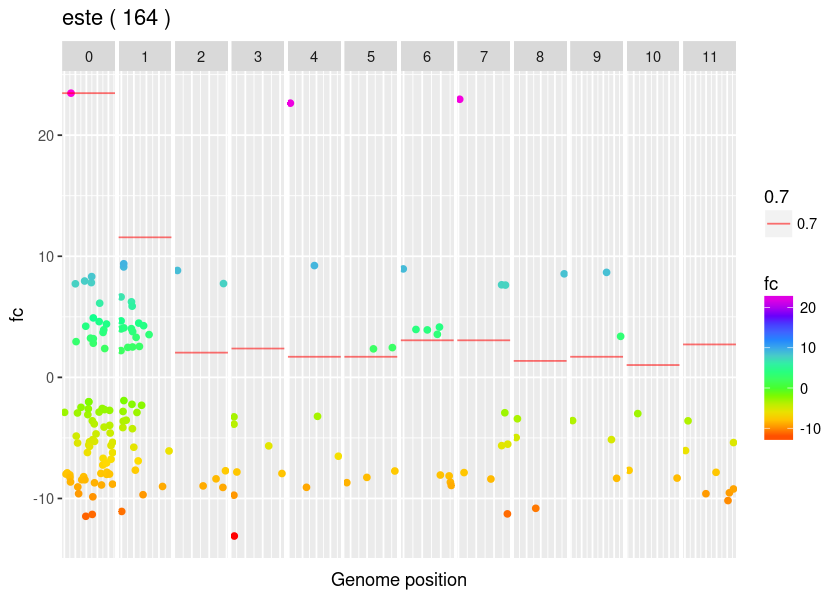

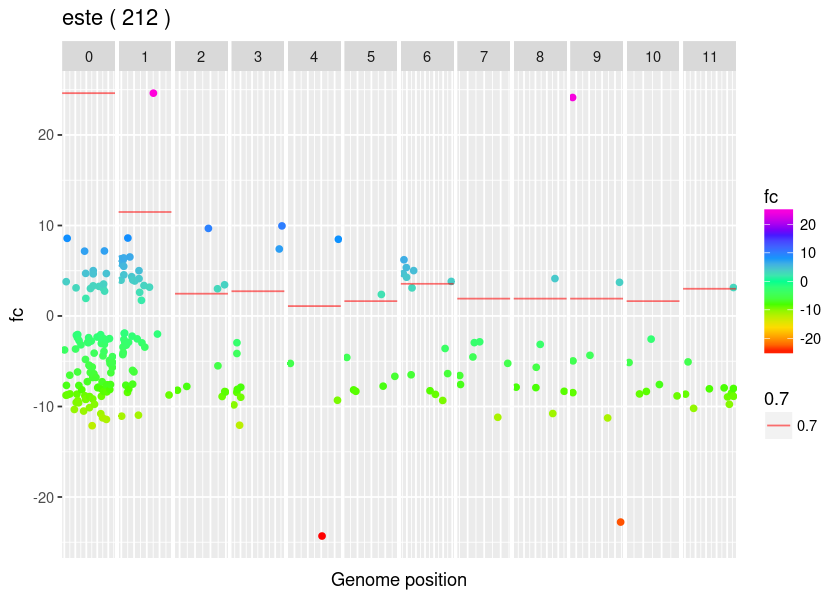

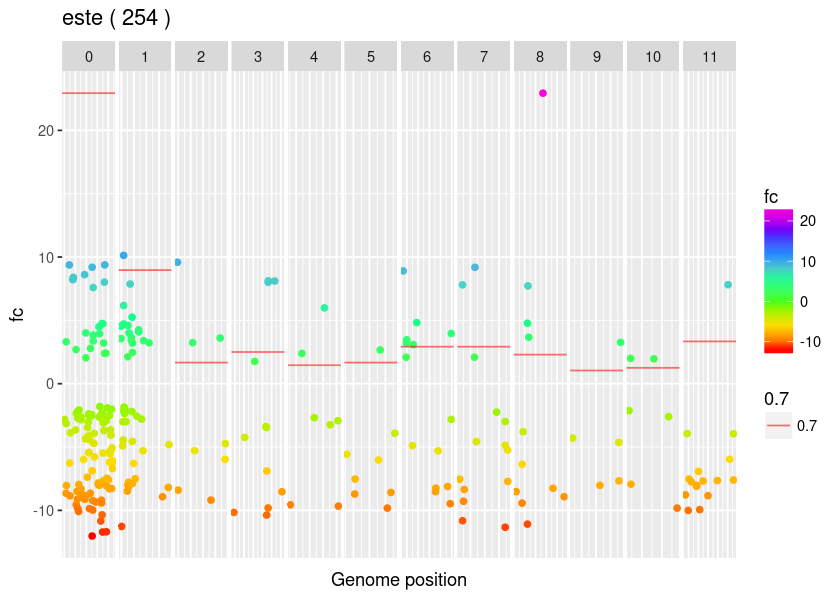

In [69]:
plotFC(c24$res, "este")
plotFC(c48$res, "este")
plotFC(c72$res, "este")